In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.QAP_solver import calculate_D, calculate_S_E, calculate_D_prime,add_depot,calculate_T
from src.optimization_methods import row_wise_optimization, greedy_scheduling
from src.utils import get_optimized_sequence, print_command
import pandas as pd
from pathlib import Path

/home/yq-mew/yq/chem1906/Projects/pipette_scheduling


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create an enpty dataframe df contains iteration, 'number of jobs','unoptimized','rowwise', 'greedy','VRP'
df = pd.DataFrame(columns=['iteration', 'number of jobs', 'unoptimized', 'rowwise', 'greedy', 'VRP'])

In [33]:
command_line_path = Path(f'/u/yq/chem1906/Projects/pipette_scheduling/analysis/real_world_task/command_line',ifnot_exists=True)
command_line_path.mkdir(parents=True, exist_ok=True)
#make a directory for the commands, unoptimized, rowwise, greedy, VRP
unoptimized_path = command_line_path / 'unoptimized'
unoptimized_path.mkdir(parents=True, exist_ok=True)
rowwise_path = command_line_path / 'rowwise'
rowwise_path.mkdir(parents=True, exist_ok=True)
greedy_path = command_line_path / 'greedy'
greedy_path.mkdir(parents=True, exist_ok=True)
vrp_path = command_line_path / 'vrp'
vrp_path.mkdir(parents=True, exist_ok=True)

In [36]:
np.random.seed(0)
source_dim = 96
dest_dim = 96
print(f'source_dim={source_dim}, dest_dim={dest_dim}')
stats = []
for i in range(1, 9):
    data_path = Path(f'/u/yq/chem1906/Projects/pipette_scheduling/analysis/real_world_task/{i}.csv')
    a = np.genfromtxt(data_path, delimiter=',')
    # the original data is (dest, source), we need to transpose it to (source, dest)
    a = a.T
    a[a>0] = 1

    jobs = np.argwhere(a)
    num_candidates = jobs.shape[0]
    print(f'num_candidates={num_candidates}')

    D_S = calculate_D(a.shape[0])
    D_D = calculate_D(a.shape[1])
    S, E = calculate_S_E(a)   
    # calculate distance matrix
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    D_prime = add_depot(D_prime)
    # VRP solver
    VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =20)
    print(f'VRP_distance: {VRP_distance}')
    
    # print the command line for the VRP
    recorder = get_optimized_sequence(VRP_recorder)
    vrp_sequence = recorder.flatten()
    vrp_sequence = vrp_sequence[vrp_sequence!=-1] -1
    vrp_command_line = print_command(vrp_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}')
    np.savetxt(vrp_path / f'{i}.csv',vrp_command_line,fmt='%s',delimiter=',')

    # calculate the cost of the non-optimized sequence
    tasks = np.array(range(jobs.shape[0]))
    tasks = tasks+1
    # if tasks.shape[0] %8 != 0, pad with -1
    if tasks.shape[0] %8 != 0:
        tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
    unoptimized_seuqnece = tasks.reshape(-1, 8)
    t = calculate_T(unoptimized_seuqnece)
    d = D_prime[1:, 1:]
    non_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    non_optimized_distance = int(non_optimized_distance)
    print(f'non_optimized_distance: {non_optimized_distance}')

    # print the command line for the unoptimized sequence
    unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs,f'source{source_dim}', f'dest{dest_dim}')
    np.savetxt(unoptimized_path/ f'{i}.csv',unoptimized_command_line,fmt='%s',delimiter=',')
    
    # calculate the cost of the row-wise optimized sequence
    index_matrix = np.zeros((source_dim,dest_dim))
    for j in range(jobs.shape[0]):
        index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
    row_wise_optimized_sequence = row_wise_optimization(index_matrix)
    if row_wise_optimized_sequence.shape[0] %8 != 0:
        row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
    t = calculate_T(row_wise_optimized_sequence)
    row_wise_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    row_wise_optimized_distance = int(row_wise_optimized_distance)
    print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

    # print the command line for the row wise optimized sequence
    row_wise_optimized_sequence = row_wise_optimized_sequence.flatten()
    row_wise_optimized_sequence = row_wise_optimized_sequence[row_wise_optimized_sequence!=-1] -1
    row_wise_command_line = print_command(row_wise_optimized_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}')
    np.savetxt(rowwise_path / f'{i}.csv',row_wise_command_line,fmt='%s',delimiter=','),

    # calculate the cost of the greedy optimized sequence
    greedy_optimized_sequence = greedy_scheduling(jobs, d)
    if greedy_optimized_sequence.shape[0] %8 != 0:
        greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
    t = calculate_T(greedy_optimized_sequence)
    greedy_optimized_distance = np.trace(np.dot(t.T, d))
    print(f'greedy_optimized_distance: {greedy_optimized_distance}')

    # print the command line for the greedy optimized sequence
    greedy_optimized_sequence = greedy_optimized_sequence.flatten()
    greedy_optimized_sequence = greedy_optimized_sequence[greedy_optimized_sequence!=-1] -1
    greedy_command_line = print_command(greedy_optimized_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}')
    np.savetxt(greedy_path / f'{i}.csv',greedy_command_line,fmt='%s',delimiter=',')

    # append the results to the df
    stats.append([i, num_candidates, non_optimized_distance, row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
    
# convert the stats to the dataframe
stats = pd.DataFrame(stats, columns=['iteration', 'number of jobs', 'unoptimized', 'rowwise', 'greedy', 'VRP'])
# append the stats to the df
df = pd.concat([df, stats], ignore_index=True)
print(df)


source_dim=96, dest_dim=96
num_candidates=88
VRP_distance: 0
non_optimized_distance: 0
row_wise_optimized_distance: 0
greedy_optimized_distance: 82.0
num_candidates=309
VRP_distance: 277
non_optimized_distance: 461
row_wise_optimized_distance: 344
greedy_optimized_distance: 484.0
num_candidates=293
VRP_distance: 288
non_optimized_distance: 460
row_wise_optimized_distance: 430
greedy_optimized_distance: 487.0
num_candidates=300
VRP_distance: 281
non_optimized_distance: 448
row_wise_optimized_distance: 429
greedy_optimized_distance: 490.0
num_candidates=308
VRP_distance: 298
non_optimized_distance: 455
row_wise_optimized_distance: 440
greedy_optimized_distance: 513.0
num_candidates=295
VRP_distance: 289
non_optimized_distance: 422
row_wise_optimized_distance: 413
greedy_optimized_distance: 485.0
num_candidates=295
VRP_distance: 280
non_optimized_distance: 437
row_wise_optimized_distance: 416
greedy_optimized_distance: 478.0
num_candidates=301
VRP_distance: 288
non_optimized_distance: 455

In [ ]:
# save the df to csv
df.to_csv('real_world_task_computed.csv', index=False)


In [36]:
df = pd.read_csv('real_world_task_computed.csv')
# take first 8 rows
df = df.iloc[:8, :]


Text(0, 0.5, 'Total cost')

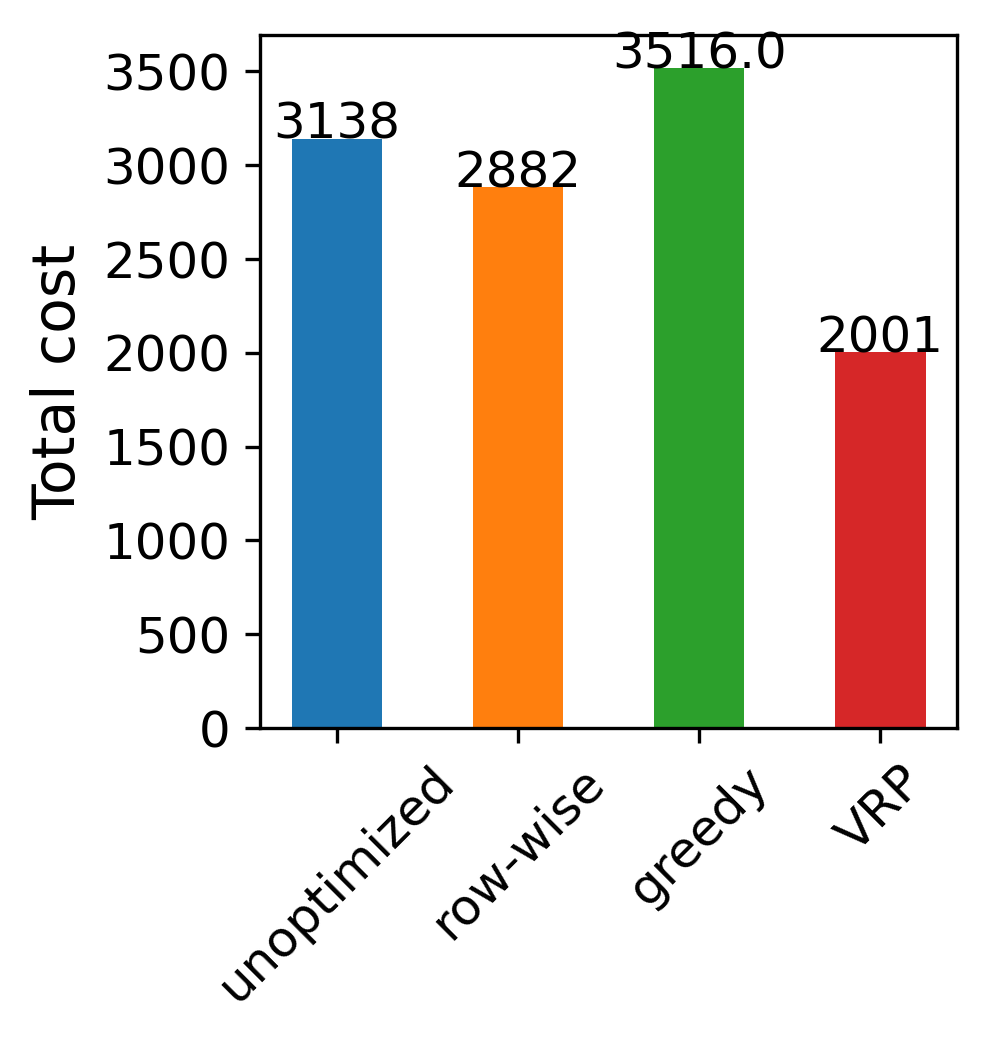

In [ ]:
# sum up the unoptimized, rowwise, greedy, VRP columns and plot the results
unoptimized_sum = df['unoptimized'].sum()
rowwise_sum = df['rowwise'].sum()
greedy_sum = df['greedy'].sum()
VRP_sum = df['VRP'].sum()
# plot the results
plt.figure(figsize=(3, 3),dpi=300)
plt.bar(['unoptimized', 'row-wise', 'greedy', 'VRP'], [unoptimized_sum, rowwise_sum, greedy_sum, VRP_sum],width=0.5,color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
#plt.title('Total cost', fontsize=16)
#plt.xlabel('Scheduling Method', fontsize=14)
# label the bars with the values

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Total cost', fontsize=14)


Text(0, 0.5, 'Execution time (s)')

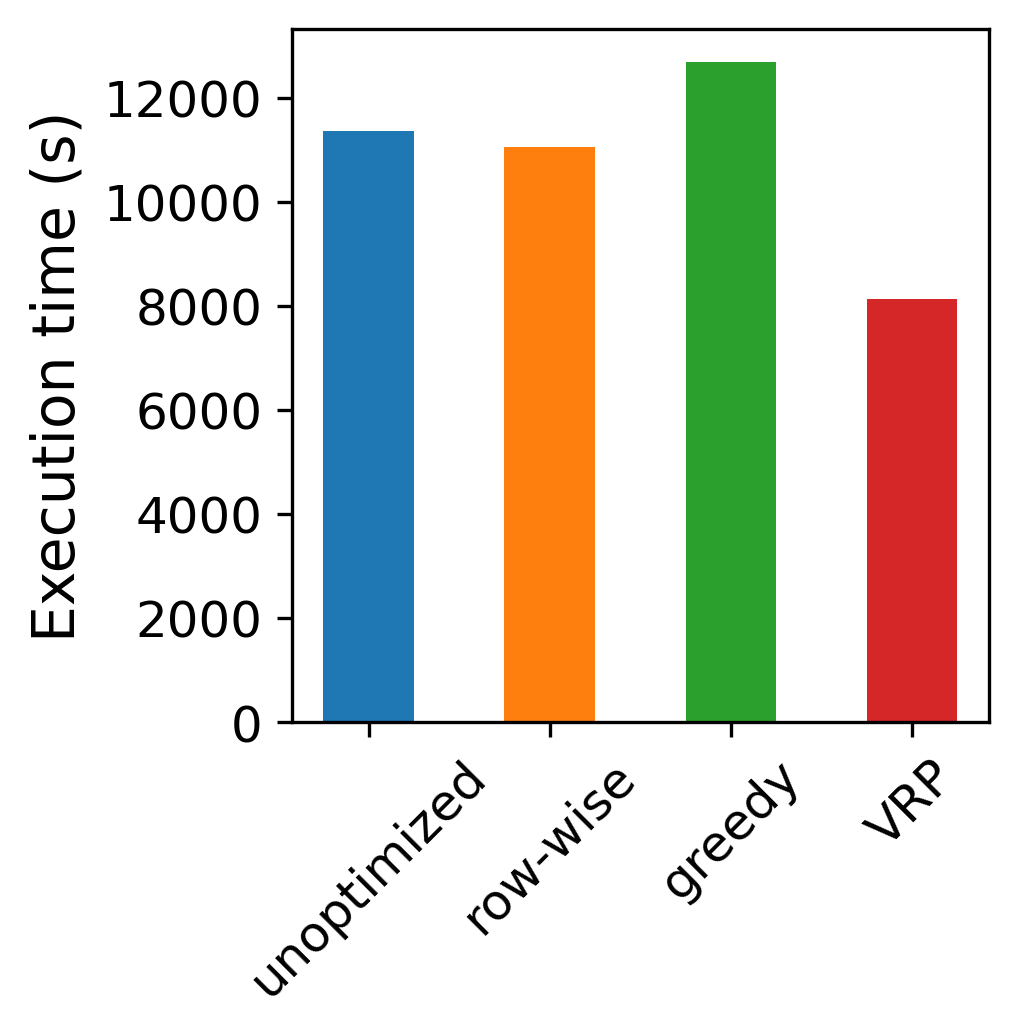

In [21]:
run_time_summary = pd.read_csv('/u/yq/chem1906/Projects/pipette_scheduling/notebooks/Real_world_summary_fast.csv')
# plot the run time sum of the different scheduling methods
plt.figure(figsize=(3, 3),dpi=300)
plt.bar(['unoptimized', 'row-wise', 'greedy', 'VRP'], [run_time_summary['Unoptimized'].sum(), run_time_summary['Row-wise'].sum(), run_time_summary['Greedy'].sum(), run_time_summary['VRP'].sum()],width=0.5,color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
#plt.title('Execution time')
#plt.xlabel('Scheduling Method', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Execution time (s)', fontsize=14)

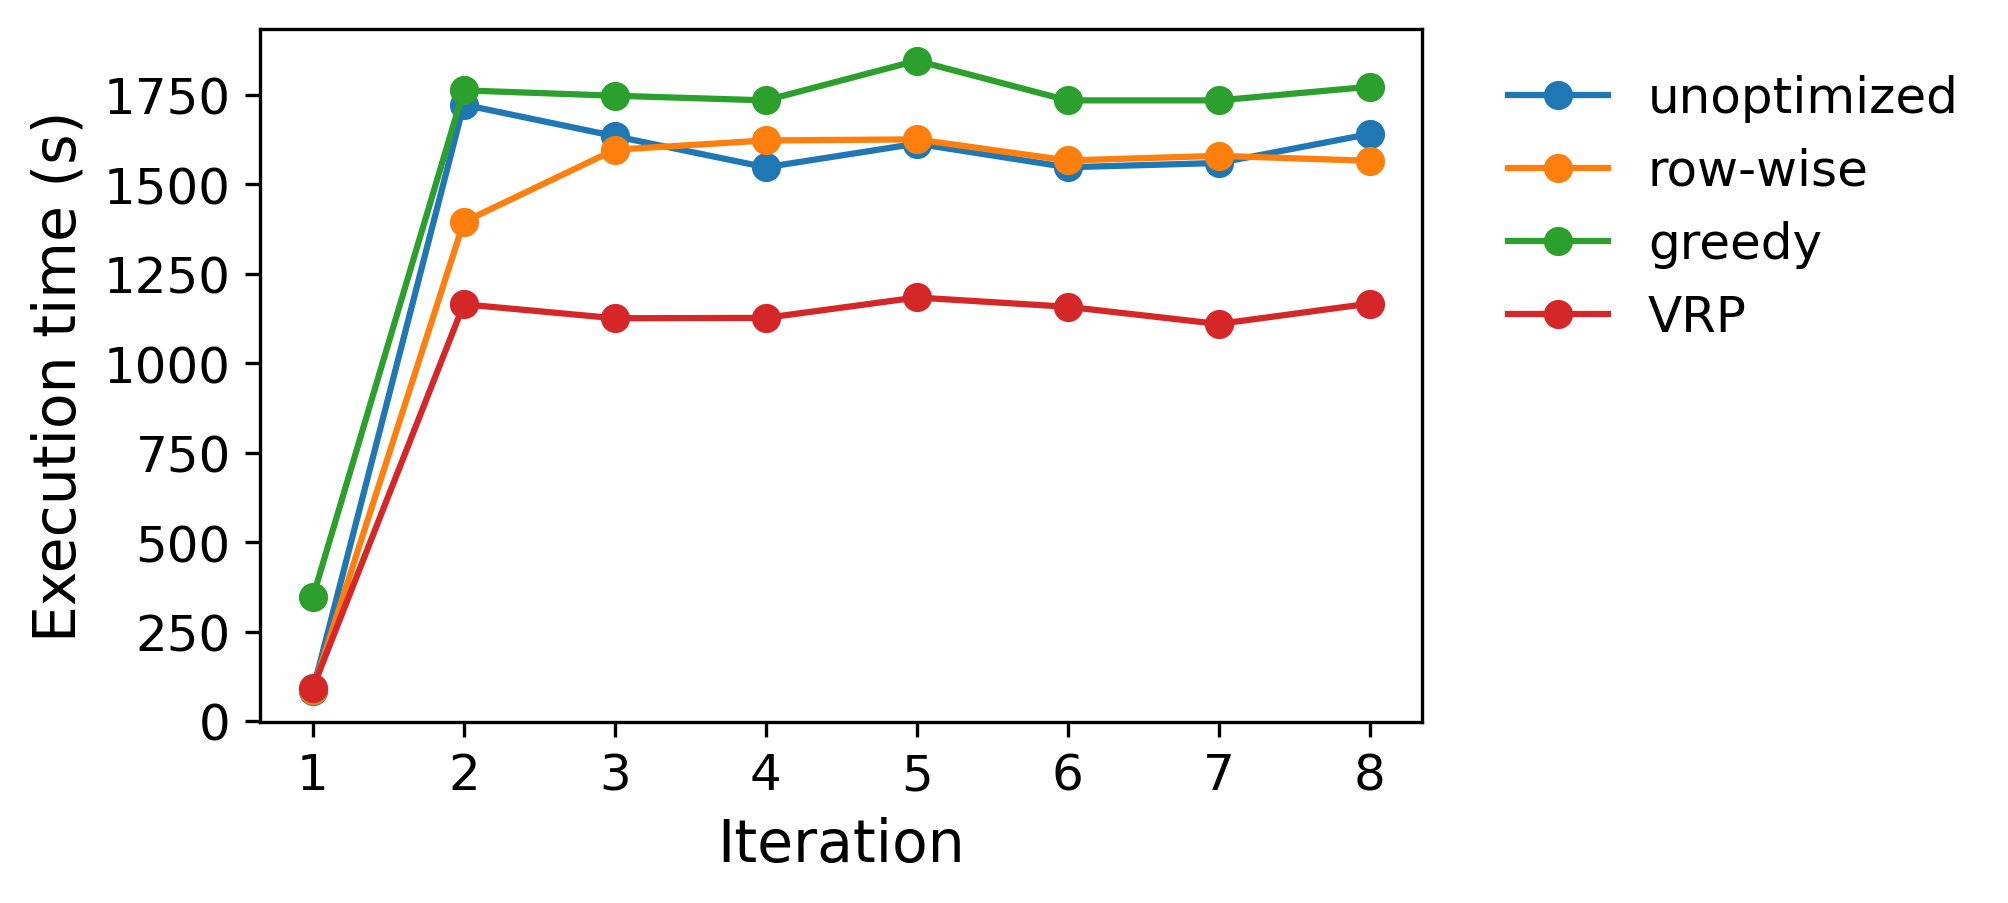

In [35]:
# plot the run time comparison of each interation of run_time_summary as dots connected by lines
plt.figure(figsize=(5, 3),dpi=300)
plt.plot(run_time_summary['Iteration'], run_time_summary['Unoptimized'], marker='o', label='unoptimized', color='#1f77b4')
plt.plot(run_time_summary['Iteration'], run_time_summary['Row-wise'], marker='o', label='row-wise', color='#ff7f0e')
plt.plot(run_time_summary['Iteration'], run_time_summary['Greedy'], marker='o', label='greedy', color='#2ca02c')
plt.plot(run_time_summary['Iteration'], run_time_summary['VRP'], marker='o', label='VRP', color='#d62728')
#plt.title('Execution time over iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Execution time (s)', fontsize=14)
# move the legend to the upper right outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fontsize=12., frameon=False)



In [22]:
run_time_summary['Iteration']

0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
Name: Iteration, dtype: int64